In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
crashes = pd.read_csv('data/Crashes.csv')
parties = pd.read_csv('data/Parties.csv')

In [9]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CASE_ID                  5094 non-null   int64  
 1   ACCIDENT_YEAR            5094 non-null   int64  
 2   PROC_DATE                5094 non-null   object 
 3   JURIS                    5094 non-null   int64  
 4   COLLISION_DATE           5094 non-null   object 
 5   COLLISION_TIME           5094 non-null   int64  
 6   OFFICER_ID               5092 non-null   object 
 7   REPORTING_DISTRICT       4721 non-null   object 
 8   DAY_OF_WEEK              5094 non-null   int64  
 9   CHP_SHIFT                5094 non-null   int64  
 10  POPULATION               5094 non-null   int64  
 11  CNTY_CITY_LOC            5094 non-null   int64  
 12  SPECIAL_COND             5094 non-null   int64  
 13  BEAT_TYPE                5094 non-null   int64  
 14  CHP_BEAT_TYPE           

In [19]:
crashes['Collision Date'] = pd.to_datetime(crashes['COLLISION_DATE'], format = 'mixed', errors = 'coerce')

<Axes: xlabel='Collision Date'>

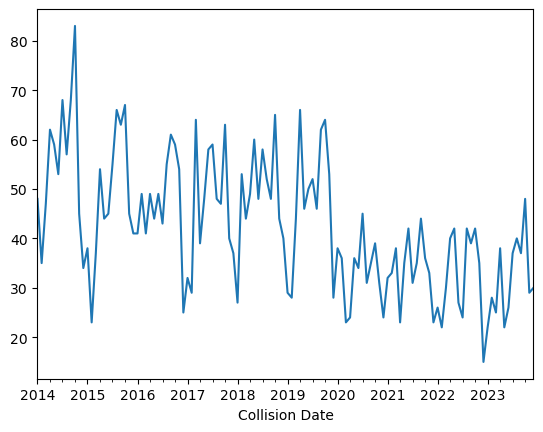

In [20]:
monthly_crashes = crashes.groupby(pd.Grouper(key = 'Collision Date', freq = 'ME')).size()
fig, ax = plt.subplots()
monthly_crashes.plot(kind= 'line', ax = ax)

We see that the number of crashes have not returned to Pre-covid numbers.